Enhancing the Locality and Breaking the Memory Bottleneck of Transformer on Time Series Forecasting

Paper: https://arxiv.org/abs/1907.00235


#### 問題設定
$N$個の単変量時系列$\{\boldsymbol{z}_{i,1:t_0}\}_{i=1}^N$の集合があるとします。ここで、$\boldsymbol{z}_{i,1:t_0}=[\boldsymbol{z}_{i,1}, \boldsymbol{z}_{i,2}, \cdots, \boldsymbol{z}_{i,t_0}]$であり、$\boldsymbol{z}_{i,t} \in R$は、時系列$i$の時刻$t$での値を表します。
すべての時系列において$\tau$だけ先、つまり$\{\boldsymbol{z}_{i,t_0+1:t0+\tau} \}_{i=1}^N$を予測します。
さらに、$\{\boldsymbol{x}_{i,1:t_0+\tau}\}_{i=1}^N$を次元$d$の関連する時間ベースの共変量ベクトルの集合(たとえば曜日や時間帯など期間全体にわたって既知であると想定さるもの)とおきます。
次の条件付き分布をモデル化することを目標とします。
$$
p(\boldsymbol{z}_{i,t_0+1:t_0+\tau}|\boldsymbol{z}_{i,1:t_0},\boldsymbol{x}_{i,1:t_0+\tau};\boldsymbol{\Phi})=\prod_{t=t_0+1}^{t_0+\tau}p(\boldsymbol{z}_{i,t}|\boldsymbol{z}_{i,1:t-1},\boldsymbol{x}_{i,1:t};\boldsymbol{\Phi})
$$

ここで、問題を1つ先の予測するモデル$p(\boldsymbol{z}_t|\boldsymbol{z}_{1:t-1},\boldsymbol{x}_{1:t};\boldsymbol{\Phi})$と簡単なものとします。
ここで、$\boldsymbol{\Phi}$はすべての時系列で共有される学習可能なパラメーターを表します。
観測と共変量の両方を十分に活用するために、次のように連結して拡張行列を取得します。

$$
\boldsymbol{y}_t=[\boldsymbol{z}_{t-1}〇\boldsymbol{x}_t]\in R^{d+1},\hspace{5mm}\boldsymbol{Y}_t=[\boldsymbol{y}_1,\cdots,\boldsymbol{y}_t]^T\in R^{t×(d+1)}
$$

ここで、$[・〇・]$は結合を表します。
$\boldsymbol{Y}_t$が与えられた場合の$\boldsymbol{z}_t$の分布を予測するために、適切なモデル $\boldsymbol{z}_t \sim f(\boldsymbol{Y}_t)$を検討します。

#### Transformer
multi-head self-attention構造を利用して Transformerで$f$をインスタンス化します。これは、self-attentionによってTransformerが長期的および短期的な依存関係の両方をキャプチャできるようになり、さまざまなattention-headが時間パターンのさまざまな側面に焦点を当てることを学習するためです。
これらの利点により、Transformerは時系列予測モデルの良い候補となります。ここではアーキテクチャを簡単に紹介することとし、詳細についてはTransformerの論文を参照してください。

self-attention layerでは、multi-head self-attention sub-layerが$Y$を$H$個の異なるquery行列$\boldsymbol{Q}_h=\boldsymbol{Y}\boldsymbol{W}_h^Q$、key行列$\boldsymbol{K}_h = \boldsymbol{Y}\boldsymbol{W}_h^K$、およびvalue行列$\boldsymbol{V}_h = \boldsymbol{Y}\boldsymbol{W}_h^V$に同時に変換します。
ここで$\boldsymbol{W}_h^Q,\boldsymbol{W}_h^K \in R^{(d+1)×d_k}$と$\boldsymbol{W}_h^V \in R^{(d+1)×d_v}$は学習可能なパラメータです。
これらの線形変換の後、scaled dot-product attentionはベクトル出力を計算します。

$$
\boldsymbol{O}_h=Attention(\boldsymbol{Q}_h,\boldsymbol{K}_h,\boldsymbol{V}_h)=softmax\bigg(\frac{\boldsymbol{Q}_h\boldsymbol{K}_h^T}{\sqrt{d_k}}・ \boldsymbol{M} \bigg)\boldsymbol{V}_h
$$

ここで、将来の情報漏えいを避けるために、マスク行列$\boldsymbol{M}$を適用して、すべての上三角要素を$-\infty$に設定することによって右方向のattentionを除外することに注意します。
その後、$\boldsymbol{O}_,\boldsymbol{O}_2,\cdots,\boldsymbol{O}_H$を連結し、再び線形変換します。
Attentionが出力されると、全結合の2つの層と中間にReLU関数を備えたposition-wise feedforward sublayerがスタックされます。

#### Enhancing the locality of Transformer

時系列のパターンは、さまざまなイベントにより、時間とともに大幅に進化する場合があります。 たとえば休日や極端な天候などですが、観測されたポイントが異常・変化点であるか、パターンの一部であるかどうかは、周囲の状況に大きく依存します。

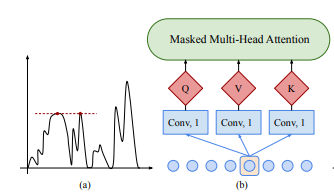

ただし、図1(a)と(b)に示すように、Transformerのself-attentionでは、形状などのローカル コンテキストを十分に活用せずに、queryとkeyの類似性がポイントごとのvalueに基づいて計算されます。
ローカルな系列に依存しないquery-keyマッチングは、観測された値が異常・変化点、またはパターンの一部であるかどうかに関してself-attentionモジュールを混乱させ、根本的な最適化の問題を引き起こす可能性があります。

この問題を緩和するために、convolutional self-attentionを提案します。
convolutional self-attentionの構造を図1(c)および(d)に示します。

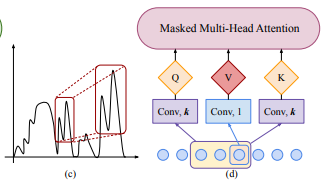

ストライド1でカーネルサイズ1の畳み込みを使用するのではなく、ストライド1でカーネルサイズ$k$のcausal convolutionを使用して、入力を(適切なパディングで)queryとkeyに変換します。
causal convolutionにより、現在の位置は将来の情報にアクセスすることはないということが保証されています。
causal convolutionを採用することにより、生成されたqueryとkeyはローカルな系列をより認識できるため、ローカルな系列情報によって類似性を計算できます。 これは、正確な予測に役立ちます。
$k=1$の場合、convolutional self-attentionは通常のself-attentionに対して劣化することに注意してください。

####  Breaking the memory bottleneck of Transformer
長さ$L$の系列の場合、セルのすべてのペア間でattention scoreを計算すると、$O(L^2)$のメモリ使用量が発生し、長い時系列のモデリングが不可能になります。
ここで、$O(\log L)$内積を計算するだけでよいLogSparse Transformerを提案します。 さらに、$O(\log L)$の層をスタックするだけで、モデルはすべてのセルの情報にアクセスできます。 したがって、メモリ使用量の総コストは$O(L(\log L)2)$となります。

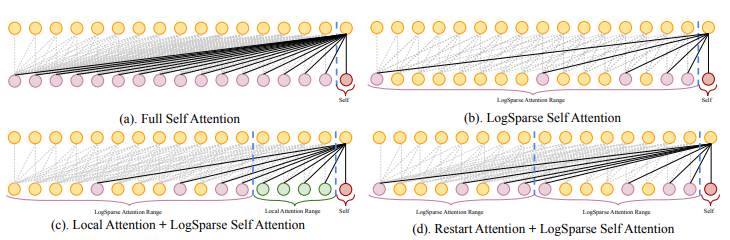


$I_l^k$を、セル$l$が計算中に注意できる$k$番目の層から$(k + 1)$番目の層までのセルのインデックスのセットとします。 Transformerの標準的なself-attentionでは、$I_l^k=\{j:j \leq l\}$であり、図 3(a)に示すように、すべてのセルが過去のすべてのセルとそれ自体に注意を向けることができます。ただし、このようなアルゴリズムでは、入力の長さの2乗で計算量が増加します。
この問題を軽減するために、インデックス$I_l^k \subset \{j : j \leq l\}$のサブセットを選択して、$|I_l^k|$が$l$とともに急激に増加しないようにします。 l とともに急速に成長しません。 効果的な方法は$|I_l^k|\propto \log L$となるようにインデックスを選択することです。

セル$l$は、$k$番目のself-attention layerで$I_l^k$によってインデックス付けされたセルの重み付けされた組み合わせであり、$I_l^k$によってインデックス付けされたセルの情報を次のレイヤーに渡すことができます。
$S_l^k$を、$l$に情報が渡された$k$番目の層までのすべてのセルのインデックスのセットとします。
すべてのセルがそれ以前のすべてのセルとそれ自体から情報を確実に受け取るようにするには、スタックされた層の数$\tilde{k}_l$は、$l = 1,\cdots,L$に対して $S_l^{\tilde{k}_l}=\{j:j \leq l\}$を満たす必要があります。
つまり、$\forall l$かつ$j \leq l$である場合、有向パス$P_{jl} = (j, p_1, p_2, \cdots, l)$が$\tilde{k}_l$個のエッジを持つことがあり、ここで$j\in I_{p_1}^1, p1\in I_{p_2}^2, \cdots, p_{k \tilde{k}_l−1} \in I_l^{\tilde{k}_l}$
各セルが指数関数的なステップ サイズとそれ自体で前のセルにのみアテンドできるようにすることで、LogSparse self-attentionを提案します。 つまり、図3(b)で示すように$\forall k$と$l$、$I_l^k=\{l−2^{[\log_2l]}, l−2^{[log2l]-1}, l −2^{[\log 2l]−2}, \cdots, l−2^0,l\}$となりあｍす。ここで$[・]$はフロア操作を表します。


In [121]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Layer, Input, Dense, Conv1D, Activation, Dropout, LayerNormalization, Reshape, Embedding, MultiHeadAttention
from tensorflow.keras import activations
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import math

import matplotlib.pyplot as plt

In [122]:
class AddPositionalEncoding(Layer):
    '''
    入力テンソルに対し、位置の情報を付与して返すレイヤー
    see: https://arxiv.org/pdf/1706.03762.pdf

    PE_{pos, 2i}   = sin(pos / 10000^{2i / d_model})
    PE_{pos, 2i+1} = cos(pos / 10000^{2i / d_model})
    '''
    def call(self, inputs):
        fl_type = inputs.dtype
        batch_size, max_length, depth = tf.unstack(tf.shape(inputs))

        depth_counter = tf.range(depth) // 2 * 2  # 0, 0, 2, 2, 4, ...
        depth_matrix = tf.tile(tf.expand_dims(depth_counter, 0), [max_length, 1])  # [max_length, depth]
        depth_matrix = tf.pow(10000.0, tf.cast(depth_matrix / depth, fl_type))  # [max_length, depth]

        # cos(x) == sin(x + π/2)
        phase = tf.cast(tf.range(depth) % 2, fl_type) * math.pi / 2  # 0, π/2, 0, π/2, ...
        phase_matrix = tf.tile(tf.expand_dims(phase, 0), [max_length, 1])  # [max_length, depth]

        pos_counter = tf.range(max_length)
        pos_matrix = tf.cast(tf.tile(tf.expand_dims(pos_counter, 1), [1, depth]), fl_type)  # [max_length, depth]

        positional_encoding = tf.sin(pos_matrix / depth_matrix + phase_matrix)
        # [batch_size, max_length, depth]
        positional_encoding = tf.tile(tf.expand_dims(positional_encoding, 0), [batch_size, 1, 1])

        return inputs + positional_encoding

In [123]:
class MultiHeadAttention(Layer):
    '''
    Multi-Head Attentionレイヤ
    
    hidden_dim : Embeddingされた単語ベクトルの長さ
    heads_num : マルチヘッドAttentionのヘッド数
       ※hidden_numはheads_numで割り切れえる値とすること
    drop_rate : 出力のDropout率

    model = MultiheadAttention(
        hidden_dim = 512,
        head_num = 8,
        drop_rate = 0.5
    )
    '''
    def __init__(self, hidden_dim, heads_num, drop_rate=0.5):
        super(MultiHeadAttention, self).__init__()
        # 入力の線形変換
        # 重み行列は[hidden_dim, hidden_dim]
        self.query = Conv1D(hidden_dim, kernel_size=3, padding='causal')
        self.key   = Conv1D(hidden_dim, kernel_size=3, padding='causal')
        self.value = Conv1D(hidden_dim, kernel_size=1)
        
        # 出力の線形変換
        self.projection = Conv1D(hidden_dim, kernel_size=1)
        
        # 出力のDropout
        self.drop = Dropout(drop_rate)
        
        self.nf = hidden_dim
        self.nh = heads_num
    
    def atten(self, query, key, value, attention_mask, training):
        """
        Attention
        
        query, key, value : 入力
        attention_mask : attention weight に適用される mask
        """
        # 各値を取得
        shape = query.shape.as_list()
        batch_size = -1 if shape[0] is None else shape[0]
        token_num = shape[2] # トークン列数
        hidden_dim = shape[1]*shape[3] # 入力チャンネル数
        
        # ここで q と k の内積を取ることで、query と key の単語間の関連度のようなものを計算します。
        # tf.matmulで最後の2成分について積を計算(それ以外は形がそろっている必要あり)
        # transpose_bで転置
        # [token_num, hidden_dim/head_num] @ [hidden_dim/head_num, token_num] = [token_num, token_num]
        scores = tf.matmul(query, key, transpose_b=True)
        
        # scoreをhidden_dimの平方根割る
        scores = tf.multiply(scores, tf.math.rsqrt(tf.cast(hidden_dim, tf.float32)))
        
        # Attention Maskがあればscoreに加算
        # attention_mask: [batch_size, token_num, token_num] 
        # マスク(参照しない部分)の場所に1、使用する部分は0とする
        # 1の部分を -無限大にする(softmax(-無限大)=0となる)
        # 1. PADを無視
        # 2. DecoderのSelf-Attentionで未来の情報を参照できないようにする

        if attention_mask is not None:
            scores = scores + attention_mask * -1e9
        # softmax を取ることで正規化します
        # input(query) の各単語に対して memory(key) の各単語のどこから情報を引いてくるかの重み
        atten_weight = tf.nn.softmax(scores)
        
        # 重みに従って value から情報を引いてきます
        # [token_num, token_num] @ [token_num, hidden_dim/head_num] = [token_num, hidden_dim/head_num]
        # input(query) の単語ごとに memory(value)の各単語 に attention_weight を掛け合わせて足し合わせた ベクトル(分散表現の重み付き和)を計算
        context = tf.matmul(atten_weight, value)
        
        # 各ヘッドの結合(reshape)
        # 入力と同じ形に変換する
        context = tf.transpose(context, [0, 2, 1, 3])
        context = tf.reshape(context, (batch_size, token_num, hidden_dim))
        
        # 線形変換
        context = self.projection(context, training=training)
        
        return self.drop(context, training=training), atten_weight

    def _split(self, x):
        """
        query, key, valueを分割する
        
        入力 shape: [batch_size, length, hidden_dim] の時
        出力 shape: [batch_size, head_num, length, hidden_dim//head_num]
        """
        # 各値を取得
        hidden_dim = self.nf
        heads_num = self.nh
        shape = x.shape.as_list()
        batch_size = -1 if shape[0] is None else shape[0]
        token_num = shape[1] # トークン列数
        
        # [batch_size, token_num, hidden_dim] -> [batch_size, token_num, head_num, hidden_dim/head_num]
        # splitだが実際は次元を拡張する処理
        x = tf.reshape(x, (batch_size, token_num, heads_num, int(hidden_dim/heads_num)))
        
        # [batch_size, token_num, head_num, hidden_dim/head_num] -> [batch_size, head_num, token_num, hidden_dim/head_num]
        x = tf.transpose(x, [0, 2, 1, 3])
        return x
    
    def call(self, x, training, memory=None, attention_mask=None, return_attention_scores=False):
        """
        モデルの実行
        
        input : 入力(query) [batch_size, token_num, hidden_dim]
        memory : 入力(key, value) [batch_size, token_num, hidden_dim]
        attention_mask : attention weight に適用される mask
            [batch_size, 1, q_length, k_length] 
            pad 等無視する部分が 1 となるようなもの(Decoderで使用)
        return_attention_scores : attention weightを出力するか
        """
        # memoryが入力されない場合、memory=input(Self Attention)とする
        if memory is None:
            memory = x

        # input -> query
        # memory -> key, value
        # [batch_size, token_num, hidden_dim] @ [hidden_dim, hidden_dim] -> [batch_size, token_num, hidden_dim] 
        query = self.query(x)
        key = self.key(memory)
        value = self.value(memory)
        
        # ヘッド数に分割する
        # 実際はreshapeで次数を1つ増やす
        # [batch_size, token_num, hidden_dim] -> [batch_size, head_num, token_num, hidden_dim/head_num]
        query = self._split(query)
        key = self._split(key)
        value = self._split(value)
        
        # attention
        # 入力と同じ形の出力
        # context: [batch_size, token_num, hidden_dim]
        # score_weightsはEncoderではNoneとする
        context, attn_weights = self.atten(query, key, value, attention_mask, training)
        if not return_attention_scores:
            return context
        else:
            return context, attn_weights

In [124]:
class FeedForwardNetwork(Layer):
    '''
    Position-wise Feedforward Neural Network
    transformer blockで使用される全結合層
    '''
    def __init__(self, hidden_dim, drop_rate):
        super().__init__()
        # 2層構造
        # 1層目：チャンネル数を増加させる
        self.filter_dense_layer = Dense(hidden_dim * 4, use_bias=True, activation='gelu')
        
        # 2層目：元のチャンネル数に戻す
        self.output_dense_layer = Dense(hidden_dim, use_bias=True)
        self.drop = Dropout(drop_rate)

    def call(self, x, training):
        '''
        入力と出力で形が変わらない
        [batch_size, token_num, hidden_dim]
        '''
        
        # [batch_size, token_num, hidden_dim] -> [batch_size, token_num, 4*hidden_dim]
        x = self.filter_dense_layer(x)
        x = self.drop(x, training=training)
        
        # [batch_size, token_num, 4*hidden_dim] -> [batch_size, token_num, hidden_dim]
        return self.output_dense_layer(x)

In [125]:
class ResidualNormalizationWrapper(Layer):
    '''
    残差接続
    output: input + SubLayer(input)
    '''
    def __init__(self, layer, drop_rate):
        super().__init__()
        self.layer = layer # SubLayer : ここではAttentionかFFN
        self.layer_normalization = LayerNormalization()
        self.drop = Dropout(drop_rate)

    def call(self, x, training, memory=None, attention_mask=None, return_attention_scores=None):
        """
        AttentionもFFNも入力と出力で形が変わらない
        [batch_size, token_num, hidden_dim]
        """
        
        params = {}
        if memory is not None:
            params['memory'] = memory
        if attention_mask is not None:
            params['attention_mask'] = attention_mask
        if return_attention_scores:
            params['return_attention_scores'] = return_attention_scores
        
        out = self.layer_normalization(x)
        if return_attention_scores:
            out, attn_weights = self.layer(out, training, **params)
            out = self.drop(out, training=training)
            return x + out, attn_weights
        else:
            out = self.layer(out, training, **params)
            out = self.drop(out, training=training)
            return x + out

In [126]:
class EncoderLayer(Layer):
    """
    encoder layer : before ->[self attention -> FF]-> next
    それぞれ残差接続とLayerNormalizationの処理が含まれる
    """
    def __init__(self, hidden_dim, heads_num, drop_rate=0.2):
        """
        hidden_numはheads_numで割り切れえる値とすること
        """
        super().__init__()
        self.atten = ResidualNormalizationWrapper(
            layer = MultiHeadAttention(hidden_dim = hidden_dim, heads_num = heads_num, drop_rate = drop_rate),
            drop_rate = drop_rate)
        
        self.ffn = ResidualNormalizationWrapper(
            layer = FeedForwardNetwork(hidden_dim = hidden_dim, drop_rate = drop_rate),
            drop_rate = drop_rate)
    
    def call(self, input, training, memory=None, attention_mask=None, return_attention_scores=False):
        """
        入力と出力で形式が変わらない
        [batch_size, token_num, hidden_dim]
        """
        
        if return_attention_scores:
            x, attn_weights = self.atten(input,training, memory, attention_mask, return_attention_scores)
            x = self.ffn(x)
            return x, attn_weights
        else:
            x = self.atten(input, training, memory, attention_mask, return_attention_scores)
            x = self.ffn(x)
            return x

In [127]:
class Encoder(Layer):
    '''
    TransformerのEncoder
    '''
    def __init__(
            self,
            hopping_num, # Multi-head Attentionの繰り返し数
            heads_num, # Multi-head Attentionのヘッド数
            hidden_dim, # Embeddingの次数
            drop_rate, # ドロップアウトの確率
    ):
        super().__init__()
        self.hopping_num = hopping_num
        
        # Position Embedding
        self.add_position_embedding = AddPositionalEncoding()
        self.input_dropout_layer = Dropout(drop_rate)

        # Multi-head Attentionの繰り返し(hopping)のリスト
        self.attention_block_list = [EncoderLayer(hidden_dim, heads_num) for _ in range(hopping_num)]
        self.output_normalization = LayerNormalization()

    def call(
            self,
            input,
            training,
            memory=None,
            attention_mask=None,
            return_attention_scores=False
    ):
        '''
        input: 入力 [batch_size, length]
        memory: 入力 [batch_size, length]
        attention_mask: attention weight に適用される mask
            [batch_size, 1, q_length, k_length] 
            pad 等無視する部分が 0 となるようなもの(Decoderで使用)
        return_attention_scores : attention weightを出力するか
        出力 [batch_size, length, hidden_dim]
        '''
        # Positional Embedding
        embedded_input = self.add_position_embedding(input)
        query = self.input_dropout_layer(embedded_input, training=training)
        
        
        if return_attention_scores:
            # MultiHead Attentionを繰り返し適用
            for i in range(self.hopping_num):
                query, atten_weights = self.attention_block_list[i](query, training, memory, attention_mask, return_attention_scores)

            # [batch_size, token_num, hidden_dim]
            return self.output_normalization(query), atten_weights
        else:
            # MultiHead Attentionを繰り返し適用
            for i in range(self.hopping_num):
                query = self.attention_block_list[i](query, training, memory, attention_mask, return_attention_scores)

            # [batch_size, token_num, hidden_dim]
            return self.output_normalization(query)

In [128]:
class DecoderLayer(Layer):
    """
    decoder layer : before ->[mask attention -> enc attention -> FF]-> next
    mask attentionは未来の情報を参照しないためのマスクを適用
    enc attentionはencoderの出力をkey, valueとする。
    それぞれ残差接続とLayerNormalizationの処理が含まれる
    """
    def __init__(self, hidden_dim, heads_num, drop_rate=0.2):
        """
        hidden_numはheads_numで割り切れえる値とすること
        """
        super().__init__()
        self.mask_atten = ResidualNormalizationWrapper(
            layer = MultiHeadAttention(hidden_dim = hidden_dim, heads_num = heads_num, drop_rate = drop_rate),
            drop_rate = drop_rate)
        
        self.enc_atten = ResidualNormalizationWrapper(
            layer = MultiHeadAttention(hidden_dim = hidden_dim, heads_num = heads_num, drop_rate = drop_rate),
            drop_rate = drop_rate)
        
        self.ffn = ResidualNormalizationWrapper(
            layer = FeedForwardNetwork(hidden_dim = hidden_dim, drop_rate = drop_rate),
            drop_rate = drop_rate)
    
    def call(self, input, training, memory=None, attention_mask=None, return_attention_scores=False):
        """
        入力と出力で形式が変わらない
        [batch_size, token_num, hidden_dim]
        """
        
        if return_attention_scores:
            x, dec_attn_weights = self.mask_atten(input, training, memory=input, attention_mask=attention_mask, return_attention_scores=return_attention_scores)
            x, encdec_attn_weights = self.enc_atten(x, training, memory=memory, attention_mask=None, return_attention_scores=return_attention_scores)
            x = self.ffn(x)
            return x, dec_attn_weights, encdec_attn_weights
        else:
            x = self.mask_atten(input, training, memory=input, attention_mask=attention_mask, return_attention_scores=False)
            x = self.enc_atten(x, training, memory=memory, attention_mask=None, return_attention_scores=False)
            x = self.ffn(x)
            return x

In [129]:
class Decoder(Layer):
    '''
    TransformerのDecoder
    '''
    def __init__(
            self,
            hopping_num, # Multi-head Attentionの繰り返し数
            heads_num, # Multi-head Attentionのヘッド数
            hidden_dim, # Embeddingの次数
            drop_rate, # ドロップアウトの確率
    ):
        super().__init__()
        self.hopping_num = hopping_num
        
        # Position Embedding
        self.add_position_embedding = AddPositionalEncoding()
        self.input_dropout_layer = Dropout(drop_rate)

        # Multi-head Attentionの繰り返し(hopping)のリスト
        self.attention_block_list = [DecoderLayer(hidden_dim, heads_num) for _ in range(hopping_num)]
        self.output_normalization = LayerNormalization()

    def call(
            self,
            input,
            training,
            memory=None,
            attention_mask=None,
            return_attention_scores=False
    ):
        '''
        input: 入力 [batch_size, length]
        memory: 入力 [batch_size, length]
        attention_mask: attention weight に適用される mask
            [batch_size, 1, q_length, k_length] 
            pad 等無視する部分が 1 となるようなもの(Decoderで使用)
        出力 [batch_size, length, hidden_dim]
        '''
        # Positional Embedding
        embedded_input = self.add_position_embedding(input)
        query = self.input_dropout_layer(embedded_input, training=training)
        
        # MultiHead Attentionを繰り返し適用
        #for i in range(self.hopping_num):
        #    query = self.attention_block_list[i](query, training, memory, attention_mask, return_attention_scores)

        # [batch_size, token_num, hidden_dim]
        #return self.output_normalization(query)
    
        if return_attention_scores:
            # MultiHead Attentionを繰り返し適用
            for i in range(self.hopping_num):
                query, dec_attn_weights, encdec_attn_weights = self.attention_block_list[i](query, training, memory, attention_mask, return_attention_scores)

            # [batch_size, token_num, hidden_dim]
            return self.output_normalization(query), dec_attn_weights, encdec_attn_weights
        else:
            # MultiHead Attentionを繰り返し適用
            for i in range(self.hopping_num):
                query = self.attention_block_list[i](query, training, memory, attention_mask, return_attention_scores)

            # [batch_size, token_num, hidden_dim]
            return self.output_normalization(query)

In [160]:
class TransformerTimeSeriesForecast(Model):
    """
    Transformerベースの時系列予測モデル
    
    """
    def __init__(
            self,
            hopping_num, # Multi-head Attentionの繰り返し数
            heads_num, # Multi-head Attentionのヘッド数
            hidden_dim, # Embeddingの次数
            drop_rate, # ドロップアウトの確率
    ):
        super().__init__()
        self.head_dim = heads_num
        
        self.encoder = Encoder(hopping_num, heads_num, hidden_dim, drop_rate)
        self.decoder = Decoder(hopping_num, heads_num, hidden_dim, drop_rate)
        
        self.fc = Dense(8)
        self.dropout = Dropout(drop_rate)
        self.final_layer = Dense(1)

    def call(self, inputs, training, return_attention_scores=False):
        enc_input, dec_input = inputs
        
        #self_attention_mask=self._create_look_ahead_mask(dec_input)
        self_attention_mask=self._create_sparse_attn_mask(dec_input)
        
        # [batch_size, token_num] -> [batch_size, token_num, hidden_dim]
        if return_attention_scores:
            enc_output, enc_atten_weights = self.encoder(enc_input, memory=enc_input, attention_mask=None,return_attention_scores=return_attention_scores)
        else:
            enc_output = self.encoder(enc_input, memory=enc_input, attention_mask=None,return_attention_scores=return_attention_scores)
        
        #dec_output = self.decoder(dec_input, memory=enc_output, attention_mask=self_attention_mask)
        if return_attention_scores:
            dec_output, dec_attn_weights, encdec_attn_weights = self.decoder(dec_input, memory=enc_output, attention_mask=self_attention_mask,return_attention_scores=return_attention_scores)
        else:
            dec_output = self.decoder(dec_input, memory=enc_output, attention_mask=self_attention_mask,return_attention_scores=return_attention_scores)
       
        
        # [batch_size, hidden_dim] -> [batch_size, NUMLABELS]
        fc_output = self.fc(dec_output)
        fc_output = self.dropout(fc_output)
        final_output = self.final_layer(fc_output)

        if return_attention_scores:
            return final_output, enc_atten_weights, dec_attn_weights, encdec_attn_weights
        else:
            return final_output
    
    def _create_look_ahead_mask(self, x):
        batch_size, length, _ = x.shape
        autoregression_array = tf.logical_not(tf.linalg.band_part(tf.ones([length, length], dtype=tf.bool), -1, 0))  # 下三角が False
        autoregression_array = tf.reshape(autoregression_array, [1, 1, length, length])
        return tf.cast(autoregression_array, dtype=tf.float32)
    
    def _create_sparse_attn_mask(self, x):
        batch_size, n, _ = x.shape
        sparse_mask = np.ones((n, n))
 
        idx_num = np.ceil(np.log2(n))
        idx = [int(n - 2**i) for i in np.arange(idx_num)[::-1]]+[n]
        idx = [0 if i in idx else 1 for i in range(1,n+1)]

        for j in range(n):
            sparse_mask[j,:] = idx[::-1][:j+1][::-1] + [1]*(n-1-j)
        sparse_mask = tf.constant(sparse_mask)
        sparse_mask = tf.reshape(sparse_mask, [1, 1, n, n])
        sparse_mask = tf.cast(sparse_mask, dtype=tf.float32)
        return sparse_mask

(654, 10, 8)
(654, 4, 8)
(654, 4, 8)


(0.0, 550.0)

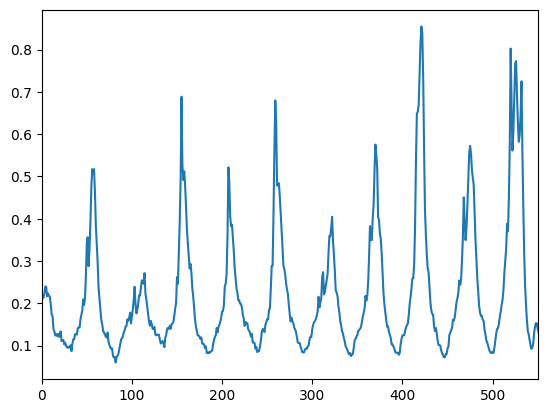

In [161]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

class minmaxscaling:
    def __init__(self,max_value, min_value, upl=0, downl=0):
        self.max = max_value + max_value*upl
        self.min = min_value - min_value*downl
    
    def translate(self, x):
        return (x - self.min) / (self.max - self.min)

window_width = 10
dmodel = 8
pred_points = 4

data = pd.read_csv('ilidata.csv')
train_data = np.array(data[['WEIGHTED_ILI']])

#scaler = StandardScaler()
#scaler.fit(train_data[:500])
#train_data = scaler.transform(train_data).ravel()

scaler = minmaxscaling(8, 0, 0.1)
train_data = scaler.translate(train_data).ravel()

emb_data = np.array([train_data[i:i+dmodel] for i in range(len(train_data)-dmodel)])

encinput = np.array([emb_data[i:i+window_width] for i in range(len(emb_data)-window_width-pred_points)])
print(encinput.shape)

decinput = np.array([emb_data[i+window_width-1:i+window_width-1+pred_points] for i in range(len(emb_data)-window_width-pred_points)])
print(decinput.shape)

y = np.array([emb_data[i+window_width:i+window_width+pred_points] for i in range(len(emb_data)-window_width-pred_points)])
print(y.shape)

enc_train, enc_test = encinput[:500,:,:], encinput[500:550,:,:]
dec_train, dec_test = decinput[:500,:,:], decinput[500:550,:,:]
y_train, y_test = y[:500,:,0], y[500:550,:,0]

enc_train = tf.constant(enc_train)
enc_test = tf.constant(enc_test)
dec_train = tf.constant(dec_train)
dec_test = tf.constant(dec_test)
y_train = tf.constant(y_train)
y_test = tf.constant(y_test)

plt.plot(y[:,-1,0]);
plt.xlim(0,550)

In [162]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import LearningRateScheduler

# 学習率を返す関数を用意する
def lr_schedul(epoch):
    lr = (dmodel**0.5) * min(epoch**0.5, epoch * (5000**(-1.5)))
    return lr


lr_decay = LearningRateScheduler(
    lr_schedul,
    # verbose=1で、更新メッセージ表示。0の場合は表示しない
    verbose=0,
)

model = TransformerTimeSeriesForecast(hopping_num=4, # Multi-head Attentionの繰り返し数
            heads_num=2, # Multi-head Attentionのヘッド数
            hidden_dim=dmodel, # Embeddingの次数
            drop_rate=0.2)

criterion = tf.keras.losses.MeanSquaredError()
optimizer = optimizers.Adam(beta_1=0.9, beta_2=0.98, epsilon=1e-09, amsgrad=False)

model.compile(loss=criterion, optimizer=optimizer, metrics=['mse'])

In [163]:
import time
start = time.time()
history=model.fit([enc_train,dec_train], y_train, batch_size=8, epochs=200, callbacks=[lr_decay],verbose=2)
elapsed_time = time.time() - start
print(elapsed_time)

Epoch 1/200
63/63 - 17s - loss: 1.8198 - mse: 1.8198 - lr: 0.0000e+00 - 17s/epoch - 268ms/step
Epoch 2/200
63/63 - 1s - loss: 1.7567 - mse: 1.7567 - lr: 8.0000e-06 - 720ms/epoch - 11ms/step
Epoch 3/200
63/63 - 1s - loss: 1.7000 - mse: 1.7000 - lr: 1.6000e-05 - 717ms/epoch - 11ms/step
Epoch 4/200
63/63 - 1s - loss: 1.4376 - mse: 1.4376 - lr: 2.4000e-05 - 718ms/epoch - 11ms/step
Epoch 5/200
63/63 - 1s - loss: 1.3028 - mse: 1.3028 - lr: 3.2000e-05 - 715ms/epoch - 11ms/step
Epoch 6/200
63/63 - 1s - loss: 1.1146 - mse: 1.1146 - lr: 4.0000e-05 - 737ms/epoch - 12ms/step
Epoch 7/200
63/63 - 1s - loss: 0.9587 - mse: 0.9587 - lr: 4.8000e-05 - 718ms/epoch - 11ms/step
Epoch 8/200
63/63 - 1s - loss: 0.8141 - mse: 0.8141 - lr: 5.6000e-05 - 730ms/epoch - 12ms/step
Epoch 9/200
63/63 - 1s - loss: 0.7673 - mse: 0.7673 - lr: 6.4000e-05 - 832ms/epoch - 13ms/step
Epoch 10/200
63/63 - 1s - loss: 0.7155 - mse: 0.7155 - lr: 7.2000e-05 - 787ms/epoch - 12ms/step
Epoch 11/200
63/63 - 1s - loss: 0.5488 - mse: 0.5

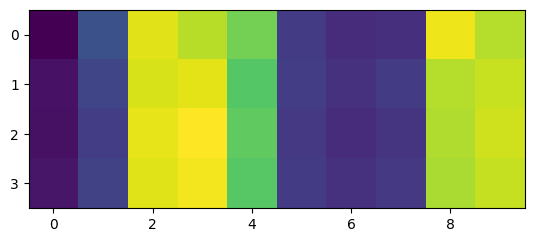

In [164]:
p, _, _, attn = model([enc_test,dec_test], return_attention_scores=True)
plt.imshow(attn[0,0])

In [165]:
pred_results = []

for j in range(len(enc_test)):
    for_pred = np.zeros((1,pred_points,dmodel))
    new_data = enc_test[j:j+1,-1:]

    for i in range(pred_points):
        for_pred[0,i,:] = new_data
        y_pred = model.predict([enc_test[j:j+1],for_pred], verbose=0)
        new_data = np.concatenate([enc_test[j:j+1,-1:,(i+1):], y_pred[0][:i+1].reshape(1,1,i+1)], axis=2)
    pred_results.append(y_pred)

pred_results = np.array(pred_results)

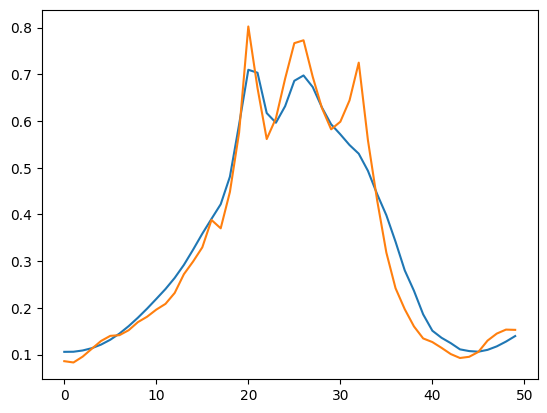

In [167]:
plt.plot(pred_results[:,0,-1,0])
plt.plot(y_test[:,-1]);
#plt.xlim(0,20)
#plt.ylim(0,4)

(616, 20, 24)
(616, 16, 24)
(616, 16, 24)


(0.0, 550.0)

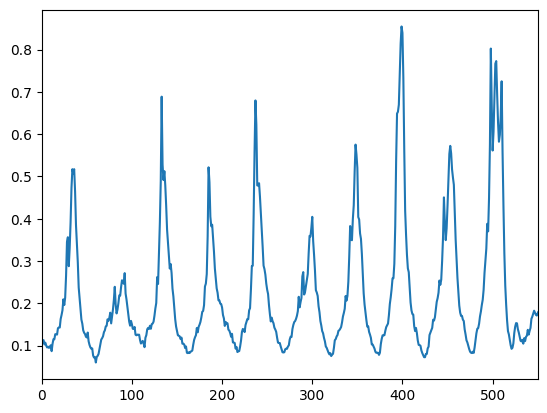

In [168]:
window_width = 20
dmodel = 24
pred_points = 16

data = pd.read_csv('ilidata.csv')
train_data = np.array(data[['WEIGHTED_ILI']])

#scaler = StandardScaler()
#scaler.fit(train_data[:500])
#train_data = scaler.transform(train_data).ravel()

scaler = minmaxscaling(8, 0, 0.1)
train_data = scaler.translate(train_data).ravel()

emb_data = np.array([train_data[i:i+dmodel] for i in range(len(train_data)-dmodel)])

encinput = np.array([emb_data[i:i+window_width] for i in range(len(emb_data)-window_width-pred_points)])
print(encinput.shape)

decinput = np.array([emb_data[i+window_width-1:i+window_width-1+pred_points] for i in range(len(emb_data)-window_width-pred_points)])
print(decinput.shape)

y = np.array([emb_data[i+window_width:i+window_width+pred_points] for i in range(len(emb_data)-window_width-pred_points)])
print(y.shape)

enc_train, enc_test = encinput[:500,:,:], encinput[500:550,:,:]
dec_train, dec_test = decinput[:500,:,:], decinput[500:550,:,:]
y_train, y_test = y[:500,:,0], y[500:550,:,0]

enc_train = tf.constant(enc_train)
enc_test = tf.constant(enc_test)
dec_train = tf.constant(dec_train)
dec_test = tf.constant(dec_test)
y_train = tf.constant(y_train)
y_test = tf.constant(y_test)

plt.plot(y[:,-1,0]);
plt.xlim(0,550)

In [170]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import LearningRateScheduler

# 学習率を返す関数を用意する
def lr_schedul(epoch):
    lr = (dmodel**0.5) * min(epoch**0.5, epoch * (5000**(-1.5)))
    return lr


lr_decay = LearningRateScheduler(
    lr_schedul,
    # verbose=1で、更新メッセージ表示。0の場合は表示しない
    verbose=0,
)

model = TransformerTimeSeriesForecast(hopping_num=4, # Multi-head Attentionの繰り返し数
            heads_num=4, # Multi-head Attentionのヘッド数
            hidden_dim=dmodel, # Embeddingの次数
            drop_rate=0.2,)

criterion = tf.keras.losses.MeanSquaredError()
optimizer = optimizers.Adam(beta_1=0.9, beta_2=0.98, epsilon=1e-09, amsgrad=False)

model.compile(loss=criterion, optimizer=optimizer, metrics=['mse'])

In [171]:
import time
start = time.time()
history=model.fit([enc_train,dec_train], y_train, batch_size=8, epochs=200, callbacks=[lr_decay],verbose=2)
elapsed_time = time.time() - start
print(elapsed_time)

Epoch 1/200
63/63 - 19s - loss: 3.0605 - mse: 3.0605 - lr: 0.0000e+00 - 19s/epoch - 294ms/step
Epoch 2/200
63/63 - 2s - loss: 2.9394 - mse: 2.9394 - lr: 1.3856e-05 - 2s/epoch - 28ms/step
Epoch 3/200
63/63 - 2s - loss: 2.5382 - mse: 2.5382 - lr: 2.7713e-05 - 2s/epoch - 39ms/step
Epoch 4/200
63/63 - 3s - loss: 1.8888 - mse: 1.8888 - lr: 4.1569e-05 - 3s/epoch - 45ms/step
Epoch 5/200
63/63 - 2s - loss: 1.3834 - mse: 1.3834 - lr: 5.5426e-05 - 2s/epoch - 34ms/step
Epoch 6/200
63/63 - 2s - loss: 1.0260 - mse: 1.0260 - lr: 6.9282e-05 - 2s/epoch - 35ms/step
Epoch 7/200
63/63 - 2s - loss: 0.7943 - mse: 0.7943 - lr: 8.3138e-05 - 2s/epoch - 34ms/step
Epoch 8/200
63/63 - 2s - loss: 0.6061 - mse: 0.6061 - lr: 9.6995e-05 - 2s/epoch - 29ms/step
Epoch 9/200
63/63 - 2s - loss: 0.4551 - mse: 0.4551 - lr: 1.1085e-04 - 2s/epoch - 30ms/step
Epoch 10/200
63/63 - 2s - loss: 0.3620 - mse: 0.3620 - lr: 1.2471e-04 - 2s/epoch - 27ms/step
Epoch 11/200
63/63 - 2s - loss: 0.2825 - mse: 0.2825 - lr: 1.3856e-04 - 2s/e

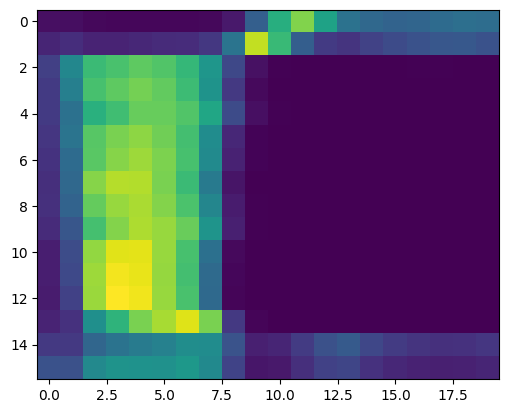

In [172]:
p, _, _, attn = model([enc_test,dec_test], return_attention_scores=True)
plt.imshow(attn[0,0])

In [173]:
pred_results = []

for j in range(len(enc_test)):
    for_pred = np.zeros((1,pred_points,dmodel))
    new_data = enc_test[j:j+1,-1:]

    for i in range(pred_points):
        for_pred[0,i,:] = new_data
        y_pred = model.predict([enc_test[j:j+1],for_pred], verbose=0)
        new_data = np.concatenate([enc_test[j:j+1,-1:,(i+1):], y_pred[0][:i+1].reshape(1,1,i+1)], axis=2)
    pred_results.append(y_pred)

pred_results = np.array(pred_results)

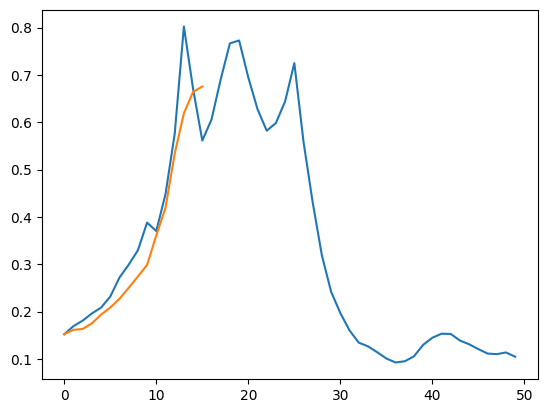

In [174]:
#plt.plot(pred_results[:,0,0,0])
plt.plot(y_test[:,0]);
plt.plot(pred_results[0,0])
#plt.xlim(0,20)
#plt.ylim(0,4)

In [96]:
n = 14

mask = np.ones((n, n))
mask

idx_num = np.ceil(np.log2(n))
idx = [int(n - 2**i) for i in np.arange(idx_num)[::-1]]+[n]
idx = [0 if i in idx else 1 for i in range(1,n+1)]

for j in range(n):
    mask[j,:] = idx[::-1][:j+1][::-1] + [1]*(n-1-j)

In [118]:
def _make_sparse_attn_mask(x_dec):
    batch_size, n, _ = x_dec.shape

    sparse_mask = np.ones((n, n))

    idx_num = np.ceil(np.log2(n))
    idx = [int(n - 2**i) for i in np.arange(idx_num)[::-1]]+[n]
    idx = [0 if i in idx else 1 for i in range(1,n+1)]

    for j in range(n):
        sparse_mask[j,:] = idx[::-1][:j+1][::-1] + [1]*(n-1-j)
    sparse_mask = tf.constant(mask)
    sparse_mask = tf.reshape(sparse_mask, [1, 1, n, n])
    sparse_mask = tf.cast(sparse_mask, dtype=tf.float32)
    return sparse_mask

In [112]:
idx_num

4.0